# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить любое из двух заданий

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

Необходимо написать функции `train_one_epoch`, `train` и `predict` по шаблонам ниже (во многом повторяют примеры с семинаров).Обратите особое внимание на функцию `predict`: она должна возвращать список лоссов по всем объектам даталоадера, список предсказанных классов для каждого объекта из даталоалера и список настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам. Если вы выполнили оба задания, то берется максимум из двух оценок.

__Бонус__. Вы получаете 5 бонусных баллов если справляетесь с обоими заданиями на 10 баллов (итого 15 баллов). В противном случае выставляется максимальная из двух оценок и ваш бонус равен нулю.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [1]:
import numpy as np
import torch
import torchvision
from tqdm import tqdm
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from IPython.display import clear_output

import os
import sys
from os.path import join
from PIL import Image
from torchvision.transforms import Compose, Normalize, Resize, ToTensor 

# Подготовка данных

In [2]:
class MyDataset(torch.utils.data.Dataset):
    """Путь до папки с папками классов (до train или val)"""
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.load_images(data_dir)
        
    def load_images(self, path):
        """Подгружаем все пути до изображений вместе с таргетами"""
        images = []
        for class_folder in tqdm(os.listdir(path)):
            target = int(class_folder[-3:])
            class_path = join(path, class_folder)
            class_items = [(join(class_path, img), target) for img in os.listdir(class_path)]
            images += class_items
        self.images = images
                                    
    def __getitem__(self, idx):
        img = Image.open(self.images[idx][0])
        target = self.images[idx][1]
        
        # некоторые картинки имеют только 1 канал => исправим это
        if len(np.array(img).shape) == 2: 
            rgbimg = Image.new("RGB", img.size)
            rgbimg.paste(img)
        else:
            rgbimg = img
            
        if self.transform is not None: rgbimg = self.transform(rgbimg)

        return (rgbimg, target)
    
    def __len__(self):
        return len(self.images)

In [3]:
transform = Compose([
    Resize((224, 224)), 
    ToTensor(), 
#     Normalize((0.5, 0.5, 0.5), (1, 1, 1)), 
])

train_dataset = MyDataset(data_dir='../input/hse-dl-hw-2/dataset/dataset/train',transform=transform)
test_dataset = MyDataset(data_dir='../input/hse-dl-hw-2/dataset/dataset/val',transform=transform)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=128,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=128,
    shuffle=True
)

100%|██████████| 200/200 [00:01<00:00, 134.02it/s]


__Посмотрим примеры картинок__

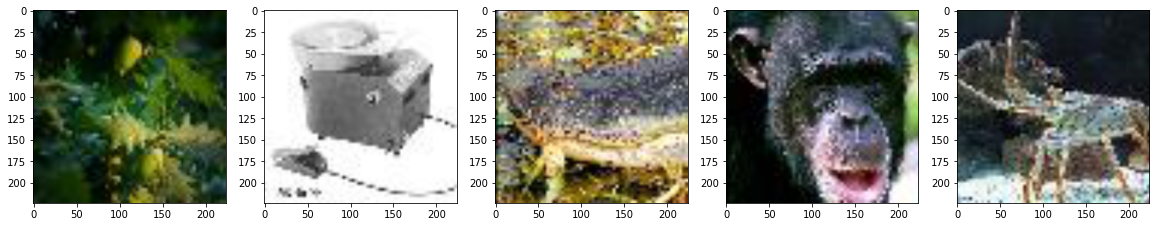

In [4]:
from matplotlib.pyplot import imshow

fig, axs = plt.subplots(ncols=5, figsize=(20,8))
for i, pic in enumerate(next(iter(train_loader))[0][:5]): 
    axs[i].imshow(pic.permute(1, 2, 0))
plt.show()

In [5]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


# Реализация модели

In [6]:
def train_model(model, optimizer, criterion, train_loader, test_loader, n_epochs=5, ylim=None):
    '''
    Функция обучения выбранной модели
    
    Параметры:
        model - модель, унаследованная от torch.nn.Module 
        optimizer - оптимизатор модели
        criterion - функция потерь из torch.nn
        train_loader - тренировочный даталоадер из torch.utils.data.Dataloader 
        test_loader - torch.utils.data.Dataloader with test set
    '''
    
    # логи по всем батчам по всем эпохам
    train_loss_total, val_mean_loss_total = [], []  
    train_acc_total, val_acc_total = [], []
    
    for num_epoch, epoch in enumerate(range(n_epochs)):
        
        # обучение эпохи
        model.train()
        train_loss_epoch, val_loss_epoch = torch.empty(0), torch.empty(0) # лоссы всех батчей по эпохе
        train_loss_epoch, val_loss_epoch = train_loss_epoch.to(device), val_loss_epoch.to(device)
        
        train_corrections_epoch = torch.empty(0) # считаем попадания модели по эпохе (для accuracy)
        train_corrections_epoch = train_corrections_epoch.to(device)
        val_corrections_epoch = torch.empty(0) 
        val_corrections_epoch = val_corrections_epoch.to(device)
        
        with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
            for num_batch, (x_batch, y_batch) in enumerate(train_loader):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                # шаг оптимизатора по одному батчу
                y_pred = model(x_batch).squeeze(1)
                loss = torch.sqrt(criterion(y_pred, y_batch))
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                # логгируем loss
                train_loss_epoch = torch.cat((train_loss_epoch, loss.unsqueeze(0))) 
                train_loss_total.append(loss.item())                                
                
                # логгируем accuracy
                targets = y_pred.argmax(1)
                train_corrections_epoch = torch.cat((train_corrections_epoch, (y_batch == targets)))
                train_acc_total.append((y_batch == targets).float().mean().item())

                # tqdm вывод
                if num_batch%(len(train_loader)//200)==0:
                    print_loss = train_loss_epoch.mean().item()
                    print_accuracy = train_corrections_epoch.mean().item()
                    pbar.set_description(f"Loss: {round(print_loss,3)} Accuracy: {round(print_accuracy,3)}") 
                pbar.update(1)

        # валидация
        model.eval()
        with tqdm(total=len(test_loader)) as pbar:
            with torch.no_grad():
                for num_batch, (x_batch, y_batch) in enumerate(test_loader):
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                    # находим лосс по батчу
                    y_pred = model(x_batch).squeeze(1)
                    loss = torch.sqrt(criterion(y_pred, y_batch))

                    # логируем loss
                    val_loss_epoch = torch.cat((val_loss_epoch, loss.unsqueeze(0))) # для среднего лосса по эпохе
                    
                    # логгируем accuracy
                    targets = y_pred.argmax(1)
                    val_corrections_epoch = torch.cat((val_corrections_epoch, (y_batch == targets)))
                    
                    # tqdm вывод
                    print_loss = val_loss_epoch.mean().item()
                    print_accuracy = val_corrections_epoch.mean().item()
                    pbar.set_description(f"Loss: {round(print_loss,3)} Accuracy: {round(print_accuracy,3)}") 
                        
                    pbar.update(1)
                    
        val_mean_loss_total.append(val_loss_epoch.mean().item()) # добавляем лосс на текущую эпоху      
        val_acc_total.append(val_corrections_epoch.mean().item())
        
        # визуализация текущего процесса обучения
        clear_output()
        plot_history(train_loss_total, val_mean_loss_total, ylim=ylim, title="loss")
        plot_history(train_acc_total, val_acc_total, ylim=ylim, title="accuracy")
        print(f"{'='*10} Epoch {num_epoch+1} {'='*10}\n")
        print("Train loss:", train_loss_epoch.mean().item())
        print("Val loss:", val_loss_epoch.mean().item())
        print("Train acc:", train_corrections_epoch.mean().item())
        print("Val acc:", val_corrections_epoch.mean().item())

In [7]:
def predict(model, test_dataloader, criterion, device):
    """
    Получение точных предсказаний по всему трен датасету
    (метрика на графиках не совсем точна, тк берет среднее значение лосса по батчам)
    """
    predictions, targets = torch.Tensor().to(device), torch.Tensor().to(device)
    
    model = model.to(device)
    model.eval()
    with tqdm(total=len(test_dataloader)) as pbar:
        with torch.no_grad():
            for x_batch, y_batch in test_dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                y_pred = model(x_batch).squeeze(1)   
                predictions = torch.cat((predictions, y_pred.argmax(1)))
                targets = torch.cat((targets, y_batch))
                
                pbar.update(1)
                pbar.set_description(f"Accuracy: {round((predictions == targets).float().mean().item(), 3)} ")  

    accuracy = (predictions == targets).float().mean().item()
    return accuracy

In [8]:
def plot_history(train_history, val_history, title="loss", ylim=None):
    """
    Функция построения графика обучения эпохи.
    - train_history - набор лоссов по всем батчам на всех эпохах
    - val_history - набор средних лоссов по батчам на всех эпохах
    """    
    # подбираем шаг для средних значений val_loss
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.title(title)
    plt.xlabel("train steps")
    plt.grid()
    if ylim:
        plt.ylim(ylim[0],ylim[1])
    
    plt.plot(train_history, label="train", zorder=1)
    plt.scatter(steps, val_history, marker="+", s=180, c="orange", label="val", zorder=2)
    
    plt.legend(loc="best")
    plt.show()

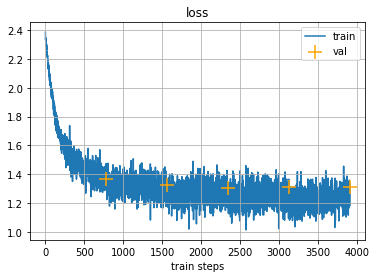

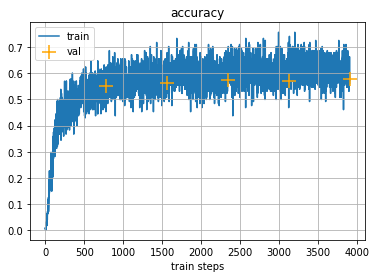

========== Epoch 5 ==========

Train loss: 1.2290681600570679
Val loss: 1.3135879039764404
Train acc: 0.6174299716949463
Val acc: 0.5769999623298645
CPU times: user 20min 7s, sys: 3min 35s, total: 23min 43s
Wall time: 28min 4s


In [28]:
%%time
from torchvision.models import resnet18

model = resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 200)

optimizer = torch.optim.Adam(model.fc.parameters())
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
model = model.to(device)

train_model(
    model=model, 
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
    n_epochs=5
)

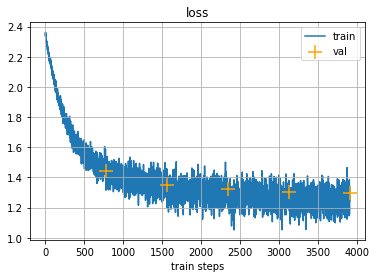

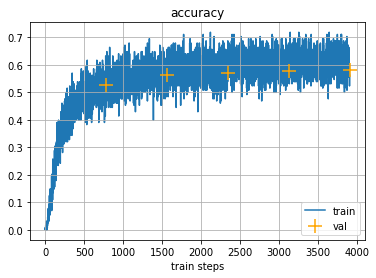

========== Epoch 5 ==========

Train loss: 1.2503278255462646
Val loss: 1.299323558807373
Train acc: 0.61176997423172
Val acc: 0.5812999606132507
CPU times: user 20min, sys: 3min 26s, total: 23min 27s
Wall time: 27min 43s


In [25]:
%%time
from torchvision.models import resnet18

model = resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 200)

optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0005)
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
model = model.to(device)

train_model(
    model=model, 
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
    n_epochs=5
)

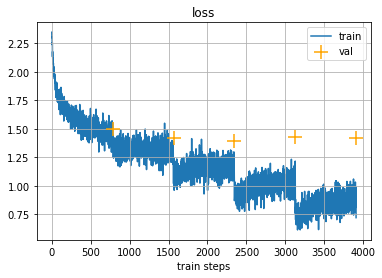

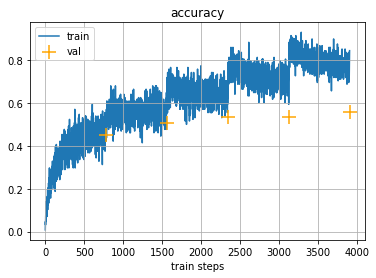

========== Epoch 5 ==========

Train loss: 0.832945704460144
Val loss: 1.4203276634216309
Train acc: 0.79926997423172
Val acc: 0.5568999648094177
CPU times: user 28min 7s, sys: 3min 11s, total: 31min 19s
Wall time: 35min 38s


In [26]:
%%time
from torchvision.models import resnet18

model = resnet18(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False

model.fc = nn.Linear(512, 200)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
model = model.to(device)

train_model(
    model=model, 
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
    n_epochs=5
)

In [9]:
from torchvision.models import resnet18
model = resnet18(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False

model.fc = nn.Linear(512, 200)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [15]:
predict(model, test_loader, criterion, device)

Accuracy: 0.576 : 100%|██████████| 79/79 [00:29<00:00,  2.70it/s]


0.5760999917984009